---
**SCRIPT FOR TRAINING M2 MODEL**

---

**David Norman Díaz Estrada**

davidnd@stud.ntnu.no


This scripts contains the procedure followed for training M2 model for image colorization. For the general training strategy and model architecture I took inspiration from [1]. Model M2 uses **VGG16** as the feature extractor (encoder) and was trained on **1000 images** (10% used for validation) from Places365 dataset [2]. 

**References:**

[1] Bhattiprolu, S. “python for microscopists”. (2020).
https://github.com/bnsreenu/python_for_microscopists/blob/master/092-autoencoder_colorize_transfer_learning_VGG16_V0.1.py

[2] Bolei Zhou, Agata Lapedriza, Aditya Khosla, Aude Oliva,
and Antonio Torralba. Places: A 10 million image database
for scene recognition. IEEE Transactions on Pattern Analysis
and Machine Intelligence, 40(6):1452–1464, 2018.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive




---
**USING VGG 16**

---





In [ ]:
#Image colorization using Autoencoders. Transfer learning using VGG.


from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import keras
import os

"""
Because we are going to replace the encoder part with VGG16, 
we don’t need it as a classifier, we need it as a feature extractor so, 
the last dense layers isn’t needed we have to pop them up.
here, we iterate on each layer except the last dense layers so, 
we add 19 layer to our model. the dimension of last layer volume is “7x7x512”. 
we will be using that latent space volume as a feature vector to be input to the decoder.
 and the decoder is going to learn the mapping from the latent space vector to ab channels. 
 we want the layers of VGG16 with its original weights without changing them, 
 so that we set the trainable parameter in each layer to false because we don’t want to train them again.
"""
from keras.applications.vgg16 import VGG16
vggmodel = VGG16()
newmodel = Sequential() 
#num = 0
for i, layer in enumerate(vggmodel.layers):
    if i<19:          #Only up to 19th layer to include feature extraction only
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False   #We don't want to train these layers again, so False. 

553476096/553467096 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                       

Data Loader:

In [ ]:
#path = 'images/colorization/'
path= '/content/gdrive/My Drive/COSI/Semestre3/VideoProcessing/places365_1300/'

#Normalize images - divide by 255
datagenerator = ImageDataGenerator(rescale=1. / 255)


#Resize images, if needed
train_generator = datagenerator.flow_from_directory(path,
                                          batch_size=1000,
                                          target_size=(224, 224),  #resizes the images to ensure dimensions are 224x224 (VGG16 requires this input size)
                                          class_mode=None,
                                          classes=["train"],
                                          shuffle='true',   #change the original order of the images for a better distribution of the training examples
                                          color_mode='rgb'
                                          )

test_generator = datagenerator.flow_from_directory(path,
                                          batch_size=300,
                                          target_size=(224, 224),   #resizes the images to ensure dimensions are 224x224
                                          class_mode=None,
                                          classes=["test"],
                                          color_mode='rgb'
                                          )

Found 1000 images belonging to 1 classes.
Found 300 images belonging to 1 classes.


Pre-Process Training Images:

In [ ]:
#Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to Lab. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.
"""

X_train =[]
Y_train =[]
counter=1
for img in train_generator[0]:
  print("Image #: ",counter)
  counter+=1
  try:
      lab = rgb2lab(img)
      X_train.append(lab[:,:,0]) 
      Y_train.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train = X_train.reshape(X_train.shape+(1,)) #dimensions to be the same for X and Y
print(X_train.shape)
print(Y_train.shape)

Image #:  1
Image #:  2
Image #:  3
Image #:  4
Image #:  5
Image #:  6
Image #:  7
Image #:  8
Image #:  9
Image #:  10
Image #:  11
Image #:  12
Image #:  13
Image #:  14
Image #:  15
Image #:  16
Image #:  17
Image #:  18
Image #:  19
Image #:  20
Image #:  21
Image #:  22
Image #:  23
Image #:  24
Image #:  25
Image #:  26
Image #:  27
Image #:  28
Image #:  29
Image #:  30
Image #:  31
Image #:  32
Image #:  33
Image #:  34
Image #:  35
Image #:  36
Image #:  37
Image #:  38
Image #:  39
Image #:  40
Image #:  41
Image #:  42
Image #:  43
Image #:  44
Image #:  45
Image #:  46
Image #:  47
Image #:  48
Image #:  49
Image #:  50
Image #:  51
Image #:  52
Image #:  53
Image #:  54
Image #:  55
Image #:  56
Image #:  57
Image #:  58
Image #:  59
Image #:  60
Image #:  61
Image #:  62
Image #:  63
Image #:  64
Image #:  65
Image #:  66
Image #:  67
Image #:  68
Image #:  69
Image #:  70
Image #:  71
Image #:  72
Image #:  73
Image #:  74
Image #:  75
Image #:  76
Image #:  77
Image #:

In [ ]:
#now we have one channel of L in each layer but, VGG16 is expecting 3 dimension, 
#so we repeated the L channel two times to get 3 dimensions of the same L channel

vggfeatures_train = []
for i, sample in enumerate(X_train):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures_train.append(prediction)
vggfeatures_train = np.array(vggfeatures_train)
print(vggfeatures_train.shape) # for each of the 513 input images it has a set of feature maps of size 7x7x512

(1000, 7, 7, 512)


Pre-Process Testing Images:

In [ ]:
#Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to Lab. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.
"""

X_test =[]
Y_test =[]
counter=1
for img in test_generator[0]:
  print("Image #: ",counter)
  counter+=1
  try:
      lab = rgb2lab(img)
      X_test.append(lab[:,:,0]) 
      Y_test.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_test = X_test.reshape(X_test.shape+(1,)) #dimensions to be the same for X and Y
print(X_test.shape)
print(Y_test.shape)

Image #:  1
Image #:  2
Image #:  3
Image #:  4
Image #:  5
Image #:  6
Image #:  7
Image #:  8
Image #:  9
Image #:  10
Image #:  11
Image #:  12
Image #:  13
Image #:  14
Image #:  15
Image #:  16
Image #:  17
Image #:  18
Image #:  19
Image #:  20
Image #:  21
Image #:  22
Image #:  23
Image #:  24
Image #:  25
Image #:  26
Image #:  27
Image #:  28
Image #:  29
Image #:  30
Image #:  31
Image #:  32
Image #:  33
Image #:  34
Image #:  35
Image #:  36
Image #:  37
Image #:  38
Image #:  39
Image #:  40
Image #:  41
Image #:  42
Image #:  43
Image #:  44
Image #:  45
Image #:  46
Image #:  47
Image #:  48
Image #:  49
Image #:  50
Image #:  51
Image #:  52
Image #:  53
Image #:  54
Image #:  55
Image #:  56
Image #:  57
Image #:  58
Image #:  59
Image #:  60
Image #:  61
Image #:  62
Image #:  63
Image #:  64
Image #:  65
Image #:  66
Image #:  67
Image #:  68
Image #:  69
Image #:  70
Image #:  71
Image #:  72
Image #:  73
Image #:  74
Image #:  75
Image #:  76
Image #:  77
Image #:

In [ ]:
#now we have one channel of L in each layer but, VGG16 is expecting 3 dimension, 
#so we repeated the L channel two times to get 3 dimensions of the same L channel

vggfeatures_test = []
counter=1
for i, sample in enumerate(X_test):
  print("Image #: ",counter)
  counter+=1
  
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures_test.append(prediction)
vggfeatures_test = np.array(vggfeatures_test)
print(vggfeatures_test.shape) # for each of the 513 input images it has a set of feature maps of size 7x7x512

Image #:  1
Image #:  2
Image #:  3
Image #:  4
Image #:  5
Image #:  6
Image #:  7
Image #:  8
Image #:  9
Image #:  10
Image #:  11
Image #:  12
Image #:  13
Image #:  14
Image #:  15
Image #:  16
Image #:  17
Image #:  18
Image #:  19
Image #:  20
Image #:  21
Image #:  22
Image #:  23
Image #:  24
Image #:  25
Image #:  26
Image #:  27
Image #:  28
Image #:  29
Image #:  30
Image #:  31
Image #:  32
Image #:  33
Image #:  34
Image #:  35
Image #:  36
Image #:  37
Image #:  38
Image #:  39
Image #:  40
Image #:  41
Image #:  42
Image #:  43
Image #:  44
Image #:  45
Image #:  46
Image #:  47
Image #:  48
Image #:  49
Image #:  50
Image #:  51
Image #:  52
Image #:  53
Image #:  54
Image #:  55
Image #:  56
Image #:  57
Image #:  58
Image #:  59
Image #:  60
Image #:  61
Image #:  62
Image #:  63
Image #:  64
Image #:  65
Image #:  66
Image #:  67
Image #:  68
Image #:  69
Image #:  70
Image #:  71
Image #:  72
Image #:  73
Image #:  74
Image #:  75
Image #:  76
Image #:  77
Image #:

Declare the Decoder architecture:

In [ ]:
#Decoder:
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', input_shape=(7,7,512)))
model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d_10 (UpSamplin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_11 (UpSamplin  (None, 28, 28, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)       

Define Function to plot accuracy and loss of Network during training:


In [ ]:
def plotHistoryNetwork(History):
  from matplotlib import pyplot as plt
  
  #Plot train and test accuracy curves:
  plt.plot(History.history['accuracy'])
  plt.plot(History.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  #Plot train and test loss curves:
  plt.figure()
  plt.plot(History.history['loss'])
  plt.plot(History.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

---
**Model M2:**

---

In [ ]:
model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
results = model.fit(x=vggfeatures_train,y=Y_train, validation_split=0.1, batch_size=16, epochs=1000)

Epoch 1/1000
57/57 [==============================] - 3s 36ms/step - loss: 0.0677 - accuracy: 0.4821 - val_loss: 0.0127 - val_accuracy: 0.6462
Epoch 2/1000
57/57 [==============================] - 2s 31ms/step - loss: 0.0134 - accuracy: 0.6267 - val_loss: 0.0123 - val_accuracy: 0.6465
Epoch 3/1000
57/57 [==============================] - 2s 30ms/step - loss: 0.0133 - accuracy: 0.6268 - val_loss: 0.0122 - val_accuracy: 0.6466
Epoch 4/1000
57/57 [==============================] - 2s 32ms/step - loss: 0.0133 - accuracy: 0.6269 - val_loss: 0.0122 - val_accuracy: 0.6466
Epoch 5/1000
57/57 [==============================] - 2s 30ms/step - loss: 0.0133 - accuracy: 0.6269 - val_loss: 0.0122 - val_accuracy: 0.6466
Epoch 6/1000
57/57 [==============================] - 2s 31ms/step - loss: 0.0133 - accuracy: 0.6269 - val_loss: 0.0122 - val_accuracy: 0.6466
Epoch 7/1000
57/57 [==============================] - 2s 31ms/step - loss: 0.0133 - accuracy: 0.6269 - val_loss: 0.0122 - val_accuracy: 0.6466

In [ ]:
model.save('colorizer_train84-92_val63-20__1000epochs_batch16_1000imgs.h5') # saving the model weights for future use

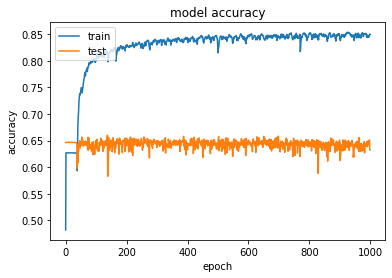

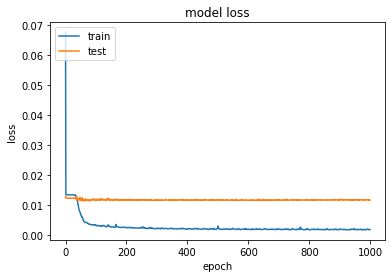

In [ ]:
plotHistoryNetwork(results)

Prediction and visualization

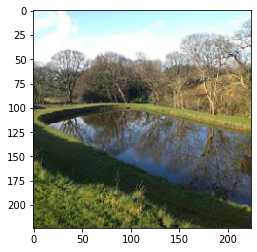

(224, 224, 3)


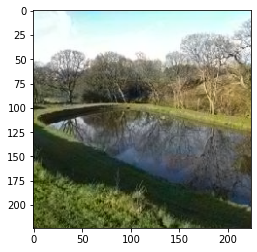

In [ ]:
# Predict and image fromt the training set:

from matplotlib import pyplot as plt

batch=0 #only one batch , then set =0
n=6 #Set image to predict,  4,5,6
img1_color=[]
img1= train_generator[batch][n]
plt.imshow(img1)
plt.show()
print(img1.shape)
#print(img1)



#img1 is from the training set, so it is already scaled to 224x224 and scalen in RGB range [0,1]

lab = rgb2lab(img1)
l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1,224,224,3))
#print(L.shape)
vggpred = newmodel.predict(L) #get features
ab = model.predict(vggpred)
#print(ab.shape)
ab = ab*128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab

plt.imshow(lab2rgb(cur))
plt.show()
#imsave('images/colorization2/vgg_result/result'+str(idx)+".jpg", lab2rgb(cur))

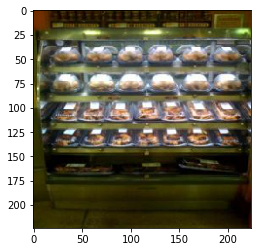

(224, 224, 3)


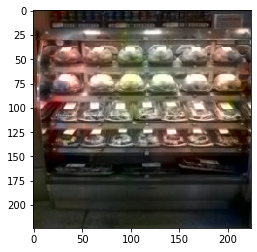

In [ ]:
# Predict and image fromt the testing set:

from matplotlib import pyplot as plt

batch=0 #only one batch , then set =0
n=15 #Set image to predict,  7, 8,9, 11,13,15
img1_color=[]
img1= test_generator[batch][n]
plt.imshow(img1)
plt.show()
print(img1.shape)
#print(img1)



#img1 is from the training set, so it is already scaled to 224x224 and scalen in RGB range [0,1]

lab = rgb2lab(img1)
l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1,224,224,3))
#print(L.shape)
vggpred = newmodel.predict(L) #get features
ab = model.predict(vggpred)
#print(ab.shape)
ab = ab*128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab

plt.imshow(lab2rgb(cur))
plt.show()
#imsave('images/colorization2/vgg_result/result'+str(idx)+".jpg", lab2rgb(cur))